## Import libraries
In this section the packages are imported.

In [1415]:
import pytz
import json
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import ta

import dash
from dash import dcc, html
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import datetime
import math
import matplotlib.pyplot as plt

## Extracting data
In this section the necessary data is extracted. 
The Fear and Greed Index (FGI) is extracted from the CNN website.
The SPY is extracted with yfinance.

In [1416]:
START_DATE = '2021-01-04'

In [1417]:
def fetch_fear_greed_index(): 
        # in this section the FGI is extracted from the CNN website
        # simulating to be a human
        headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                        "AppleWebKit/537.36 (KHTML, like Gecko) "
                        "Chrome/114.0.0.0 Safari/537.36"
        }

        # the website of CNN and start date of extraction
        BASE_URL = 'https://production.dataviz.cnn.io/index/fearandgreed/graphdata'

        # importing the data from the website
        r = requests.get('{}/{}'.format(BASE_URL, START_DATE),headers=headers)
        data = r.json()

        # the data is converted into a dataframe
        fg_data = data['fear_and_greed_historical']['data']
        fear_greed_values = {}

        # for all the data the date is transformed into a normal datetime
        for data in fg_data:
                dt = datetime.datetime.fromtimestamp(data['x'] / 1000, tz=pytz.utc)
                fear_greed_values[dt.date()] = int(math.ceil(data['y']))

        # the values are put into a dataframe
        fear_greed_values = pd.DataFrame(fear_greed_values.values(),index=fear_greed_values.keys(),columns = ['FGI'])
        fear_greed_values.index = pd.to_datetime(fear_greed_values.index)

        return fear_greed_values

fetch_fear_greed_index()

,FGI
2021-01-04,50
2021-01-05,50
2021-01-06,50
2021-01-07,50
2021-01-08,50
...,...
2025-05-23,64
2025-05-27,66
2025-05-28,64
2025-05-29,63


In [1418]:
def fetch_data():
    # SPY data
    spy = yf.download('SPY', start=START_DATE, interval='1wk',multi_level_index=False)
    spy.dropna(inplace=True)

    # Technical Indicators
    spy['200DMA'] = spy['Close'].rolling(window=28).mean()
    spy['200DMA perc'] = ((spy['Close'] - spy['200DMA'])/spy['200DMA']) * 100
    spy['50DMA'] = spy['Close'].rolling(window=7).mean()

    spy['RSI'] = ta.momentum.RSIIndicator((spy['Close'].squeeze()), window=14).rsi()
    spy['RSI_Smoothed'] = spy['RSI'].ewm(span=17, adjust=False).mean()

    macd = ta.trend.MACD(spy['Close'].squeeze())
    spy['MACD'] = macd.macd()
    spy['MACD_signal'] = macd.macd_signal()
    spy['MACD_hist'] = macd.macd_diff()
    
    return spy

def fetch_vix():
    vix = yf.download('^VIX', start=START_DATE, interval='1d')
    return vix['Close']

fetch_data()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,200DMA,200DMA perc,50DMA,RSI,RSI_Smoothed,MACD,MACD_signal,MACD_hist
Date,,,,,,,,,,,,,
2021-01-04,358.996582,359.213133,343.516583,353.394017,425078700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-11,353.761292,358.874204,351.878080,355.785738,306035100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-18,360.522003,362.471134,354.749956,356.247105,213770000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-25,348.460083,363.318622,346.765175,361.265928,457381600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-01,365.069916,365.785545,348.751903,351.896862,288507800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,566.760010,568.380005,541.520020,551.390015,312393800,578.541987,-2.036495,542.996926,50.500138,48.674362,-7.436235,-2.262680,-5.173555
2025-05-05,564.340027,570.309998,556.039978,562.570007,245246100,578.148170,-2.388340,543.290000,49.809893,48.800532,-6.350295,-3.080203,-3.270092
2025-05-12,594.200012,594.500000,577.039978,581.469971,360544500,579.104685,2.606666,548.795720,57.524460,49.769857,-3.045126,-3.073187,0.028062


In [1419]:
# data = fetch_data()
# df_indicators['buy'] = np.where((df_indicators['FGI'] < 30) & (df_indicators['RSI'] < 40),1,0)
# df_indicators['sell'] = np.where((df_indicators['FGI'] > 70) & (df_indicators['RSI'] > 60),1,0)

In [1420]:
# df_indicators['200DMA perc'] = (df_indicators['Close'] - df_indicators['200DMA'])/df_indicators['200DMA']*100
# df_indicators

In [1421]:
# arr = np.where((df_indicators['MACD']>df_indicators['MACD_signal']) & (df_indicators['MACD']<0),1.0,0.0)
# diff_arr = np.insert(np.diff(arr), 0, np.nan)
# df_indicators['signal macd'] = diff_arr


In [1422]:
# arr = np.where((df_indicators['^VIX']<15),1.0,0.0)
# diff_arr = np.insert(np.diff(arr), 0, np.nan)
# df_indicators['vix signal'] = diff_arr
# df_indicators

In [1423]:

# fetching and concatenating all data
data = fetch_data()
fgi = fetch_fear_greed_index()
vix = fetch_vix()
indicator_total = pd.concat([data, fgi, vix],axis=1)

# buy/sell signal MACD
indicator_total['buy'] = ((indicator_total['FGI']*15) + (indicator_total['RSI']*5) + (25*indicator_total['200DMA perc']))/indicator_total['Close']
# 16 weken = 210 dagen
indicator_total['local high'] = indicator_total['buy'].rolling(window=70, min_periods=1).max()

# Bereken de procentuele afname ten opzichte van de piek (bijvoorbeeld: -20% = 20% lager dan de piek)
indicator_total['buy signal_drawdown_pct'] = ((indicator_total['buy'] - indicator_total['local high']) / indicator_total['local high']) * 100
indicator_total['buy_bin_light'] = ((indicator_total['buy signal_drawdown_pct']<-70) & (indicator_total['buy signal_drawdown_pct']>-80)).astype(int)
indicator_total['buy_bin_heavy'] = (indicator_total['buy signal_drawdown_pct']<-80).astype(int)*2

df_rsi = indicator_total[['RSI_Smoothed','RSI','Close']].dropna()
arr = np.where((df_rsi['RSI_Smoothed']<65),1.0,0.0)
diff_arr = np.insert(np.diff(arr), 0, np.nan)
df_rsi['sell'] = diff_arr

# indicator_total['sell'] = ((indicator_total['FGI'] > 70) & (indicator_total['RSI_Smoothed'] > 63)).astype(int)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [1424]:
df_rsi

,RSI_Smoothed,RSI,Close,sell
2021-04-05,70.313614,70.313614,388.730377,NaN
2021-04-12,70.595444,72.850083,394.181244,0.0
2021-04-19,70.779384,72.250904,393.689972,0.0
2021-04-26,70.972018,72.513093,394.219025,0.0
2021-05-03,71.389177,74.726447,398.772400,0.0
...,...,...,...,...
2025-04-28,48.674364,50.500138,566.760010,0.0
2025-05-05,48.800534,49.809893,564.340027,0.0
2025-05-12,49.769859,57.524461,594.200012,0.0
2025-05-19,50.138082,53.083866,579.109985,0.0


In [1425]:
indicator_total

,Close,High,Low,Open,Volume,200DMA,200DMA perc,50DMA,RSI,RSI_Smoothed,MACD,MACD_signal,MACD_hist,FGI,^VIX,buy,local high,buy signal_drawdown_pct,buy_bin_light,buy_bin_heavy
2021-01-04,358.996674,359.213225,343.516670,353.394107,425078700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,26.969999,NaN,NaN,NaN,0,0
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,25.340000,NaN,NaN,NaN,0,0
2021-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,25.070000,NaN,NaN,NaN,0,0
2021-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,22.370001,NaN,NaN,NaN,0,0
2021-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,21.559999,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-26,589.390015,593.200012,578.429993,586.070007,382958538.0,578.821489,1.82587,567.264291,55.598503,50.744796,0.326803,-2.161426,2.488229,NaN,NaN,NaN,2.285071,NaN,0,0
2025-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,18.959999,NaN,2.285071,NaN,0,0
2025-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,19.309999,NaN,2.285071,NaN,0,0
2025-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,19.180000,NaN,2.285071,NaN,0,0


In [1426]:
# print('On these dates you should buy:',indicator_total[indicator_total['buy_bin']==1].index)

In [1427]:

def create_technical_chart(spy,df_rsi):
    fgi = spy['FGI']
    fig = make_subplots(
        rows=6, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.03,
        row_heights=[0.4, 0.2, 0.2, 0.2,0.2,0.4],
        subplot_titles=("SPY Close Price", "RSI", "MACD", "Fear & Greed Index","VIX","Overall buy"),
        specs = [[{}],[{}],[{}],[{}],[{}],[{"secondary_y": True}]]
    )

    # Row 1: Close Price & 200DMA
    fig.add_trace(go.Scatter(x=spy.index, y=spy['Close'], name="Close", line=dict(color='blue'),connectgaps=True), row=1, col=1)
    fig.add_trace(go.Scatter(x=spy.index, y=spy['200DMA'], name="200DMA", line=dict(color='black'),connectgaps=True), row=1, col=1)
    fig.add_trace(go.Scatter(x=spy.index, y=spy['50DMA'], name="50DMA", line=dict(color='grey'),connectgaps=True), row=1, col=1)

    # Row 2: RSI
    fig.add_trace(go.Scatter(x=spy.index, y=spy['RSI'], name="RSI", line=dict(color='orange'),connectgaps=True), row=2, col=1)
    fig.add_trace(go.Scatter(x=spy.index, y=spy['RSI_Smoothed'], name="RSI", line=dict(color='coral'),connectgaps=True), row=2, col=1)

    fig.add_shape(type='line', x0=spy.index[0], x1=spy.index[-1], y0=65, y1=65, line=dict(dash='dash'), row=2, col=1)
    fig.add_shape(type='line', x0=spy.index[0], x1=spy.index[-1], y0=40, y1=40, line=dict(dash='dash'), row=2, col=1)

    # Row 3: MACD
    fig.add_trace(go.Scatter(x=spy.index, y=spy['MACD'], name="MACD", line=dict(color='green'),connectgaps=True), row=3, col=1)
    fig.add_trace(go.Scatter(x=spy.index, y=spy['MACD_signal'], name="Signal", line=dict(color='red'),connectgaps=True), row=3, col=1)
    fig.add_trace(go.Bar(x=spy.index, y=spy['MACD_hist'], name="Histogram", marker_color='gray'), row=3, col=1)

    # Row 4: FGI (if available)
    if fgi is not None:
        fig.add_trace(go.Scatter(x=fgi.index, y=fgi, name="FGI", line=dict(color='purple'),connectgaps=True), row=4, col=1)
    fig.add_shape(type='line', x0=spy.index[0], x1=spy.index[-1], y0=70, y1=70, line=dict(dash='dash'), row=4, col=1)
    fig.add_shape(type='line', x0=spy.index[0], x1=spy.index[-1], y0=30, y1=30, line=dict(dash='dash'), row=4, col=1)
    
    # Row 5: VIX 
    fig.add_trace(go.Scatter(x=spy.index, y=spy['^VIX'], name="VIX", line=dict(color='yellow'),connectgaps=True), row=5, col=1)
    fig.add_shape(type='line', x0=spy.index[0], x1=spy.index[-1], y0=15, y1=15, line=dict(dash='dash'), row=5, col=1)

    # Row 6: Overall buy and sell signals 
    fig.add_trace(go.Scatter(x=spy.index, y=spy['buy signal_drawdown_pct']*0.05, name="buy", mode='lines', line=dict(color='green'),connectgaps=True), row=6, col=1,secondary_y=False)
    fig.add_trace(go.Scatter(x=spy.index, y=spy['buy_bin_light'], name="buy light", mode='lines',line=dict(color='lightgreen',shape='hv')), row=6, col=1, secondary_y=False)
    fig.add_trace(go.Scatter(x=spy.index, y=spy['buy_bin_heavy'], name="buy strong", mode='lines',line=dict(color='green',shape='hv')), row=6, col=1, secondary_y=False)
    # fig.add_trace(go.Scatter(x=spy.index, y=spy['sell'], name="sell", mode='lines',line=dict(color='red',shape='hv')), row=6, col=1, secondary_y=False)


    fig.add_trace(go.Scatter(x=spy.index, y=spy['Close'], name="Close", line=dict(color='blue'),connectgaps=True), row=6, col=1,secondary_y=True)
    
    
    # # Buy signals (green triangle up)
    # buy_signals = df_macd[df_macd['buy macd'] == 1]
    # fig.add_trace(go.Scatter(
    #     x=buy_signals.index,
    #     y=buy_signals['Close'],
    #     mode='markers',
    #     name='Buy Signal',
    #     marker=dict(symbol='triangle-up', color='green', size=10)
    # ),row=6, col=1,secondary_y=True)

    # # Buy signals (green triangle up)
    # buy_signals = df_rsi[df_rsi['sell RSI'] == -1]
    # fig.add_trace(go.Scatter(
    #     x=buy_signals.index,
    #     y=buy_signals['Close'],
    #     mode='markers',
    #     name='Buy Signal',
    #     marker=dict(symbol='triangle-down', color='red', size=10)
    # ),row=6, col=1,secondary_y=True)

    # Sell signals (red triangle down)
    sell_signals = df_rsi[df_rsi['sell'] == 1]
    fig.add_trace(go.Scatter(
        x=sell_signals.index,
        y=sell_signals['Close'],
        mode='markers',
        name='Sell Signal',
        marker=dict(symbol='triangle-down', color='red', size=10)
    ),row=6, col=1,secondary_y=True)

    # # VIX Sell signals (red triangle down)
    # sell_signals = spy[spy['vix signal'] == 1]
    # fig.add_trace(go.Scatter(
    #     x=sell_signals.index,
    #     y=sell_signals['Close'],
    #     mode='markers',
    #     name='Sell Signal',
    #     marker=dict(symbol='triangle-down', color='yellow', size=10)
    # ),row=6, col=1,secondary_y=True)

    # fig.update_yaxes(range=[0, 1.5], row=6, col=1)


    fig.update_layout(
        height=1100,
        title_text="SPY Technical Indicators",
        showlegend=True
    )
    return fig

create_technical_chart(indicator_total,df_rsi)

In [1428]:
print('buy signal medium',indicator_total[indicator_total['buy_bin_light']==1].index)
print('buy signal strong',indicator_total[indicator_total['buy_bin_heavy']==2].index)
print('sell signal',df_rsi[df_rsi['sell']==1].index)

buy signal medium DatetimeIndex(['2022-03-07', '2022-10-03', '2022-10-10', '2023-10-23',
               '2025-03-03', '2025-03-10', '2025-04-14'],
              dtype='datetime64[ns]', freq=None)
buy signal strong DatetimeIndex(['2022-05-02', '2022-05-09', '2022-05-16', '2022-06-13',
               '2022-09-26', '2025-03-31', '2025-04-07'],
              dtype='datetime64[ns]', freq=None)
sell signal DatetimeIndex(['2022-01-03', '2024-12-30'], dtype='datetime64[ns]', freq=None)


In [1429]:
indicator_total.loc['2022-01-31':]


,Close,High,Low,Open,Volume,200DMA,200DMA perc,50DMA,RSI,RSI_Smoothed,MACD,MACD_signal,MACD_hist,FGI,^VIX,buy,local high,buy signal_drawdown_pct,buy_bin_light,buy_bin_heavy
2022-01-31,428.130341,437.118485,419.647869,421.012307,629246600.0,430.831353,-0.62693,436.867667,49.924096,58.920156,5.028701,8.588085,-3.559384,30.0,24.830000,1.597521,3.724289,-57.105346,0,0
2022-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,21.959999,NaN,3.724289,NaN,0,0
2022-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,22.090000,NaN,3.724289,NaN,0,0
2022-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,24.350000,NaN,3.724289,NaN,0,0
2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,23.219999,NaN,3.724289,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-26,589.390015,593.200012,578.429993,586.070007,382958538.0,578.821489,1.82587,567.264291,55.598503,50.744796,0.326803,-2.161426,2.488229,NaN,NaN,NaN,2.285071,NaN,0,0
2025-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,18.959999,NaN,2.285071,NaN,0,0
2025-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,19.309999,NaN,2.285071,NaN,0,0
2025-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,19.180000,NaN,2.285071,NaN,0,0


In [1430]:
buy_med = indicator_total[indicator_total['buy_bin_light']==1].index
buy_strong = indicator_total[indicator_total['buy_bin_heavy']==2].index
sell = df_rsi[df_rsi['sell']==1].index

start_cap = 14000
start_date = '2022-01-31'
shares_bought = 0
spend = 0
winst = 0
extra_sold = 0
shares_boughts = []
worths = []
winsts = []
spends = []
start_caps = []
extra_solds=[]
# indicator_total_cut = indicator_total.loc['2022-01-31':]


for index, rows in indicator_total.iterrows():
    
    # per date if buy or sell
    if index > pd.to_datetime(start_date):

        if start_cap > 0:    
            if index in buy_med:
                shares_bought += 1000/rows['Close'] 
                # shares_boughts.append(shares_bought)
                start_cap = start_cap - 1000
                spend += 1000
                spends.append(spend)

            if index in buy_strong:
                shares_bought += 2000/rows['Close'] 
                # shares_boughts.append(shares_bought)
                start_cap = start_cap - 2000
                spend += 2000
                spends.append(spend)

        if index in sell:
            shares_bought -= (0.5*last_worth)/rows['Close']
            # shares_boughts.append(shares_bought)
            start_cap = start_cap + 0.5*last_worth
            extra_sold += 0.5*last_worth
            extra_solds.append(extra_sold)
        else:
            extra_sold= extra_sold

    if shares_bought is not 0:
        worth = shares_bought*rows['Close'] + extra_sold
        worths.append(worth)
        
        winst = worth - spend
        winsts.append(winst)
        start_caps.append(start_cap)
        shares_boughts.append(shares_bought)
        if not np.isnan(worth):
            last_worth = worth
    else:
        worths.append(0)
        winsts.append(0)
        start_caps.append(14000)
        shares_boughts.append(0)


<>:49: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<>:49: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

C:\Users\bwava\AppData\Local\Temp\ipykernel_35688\2679165311.py:49: SyntaxWarning:

"is not" with a literal. Did you mean "!="?



In [1431]:
# STRATEGY II
shares_bought_II = 14000 / indicator_total.loc[start_date,'Close']
winst_II = (indicator_total.loc[start_date:,'Close'] * shares_bought_II)-14000
winst_II

2022-01-31       0.00000
2022-02-01           NaN
2022-02-02           NaN
2022-02-03           NaN
2022-02-04           NaN
                 ...    
2025-05-26    5273.24327
2025-05-27           NaN
2025-05-28           NaN
2025-05-29           NaN
2025-05-30           NaN
Name: Close, Length: 858, dtype: float64

In [1432]:
indicator_total.loc[start_date:].index

DatetimeIndex(['2022-01-31', '2022-02-01', '2022-02-02', '2022-02-03',
               '2022-02-04', '2022-02-07', '2022-02-08', '2022-02-09',
               '2022-02-10', '2022-02-11',
               ...
               '2025-05-19', '2025-05-20', '2025-05-21', '2025-05-22',
               '2025-05-23', '2025-05-26', '2025-05-27', '2025-05-28',
               '2025-05-29', '2025-05-30'],
              dtype='datetime64[ns]', length=858, freq=None)

c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

Text(0.5, 1.0, 'winst')

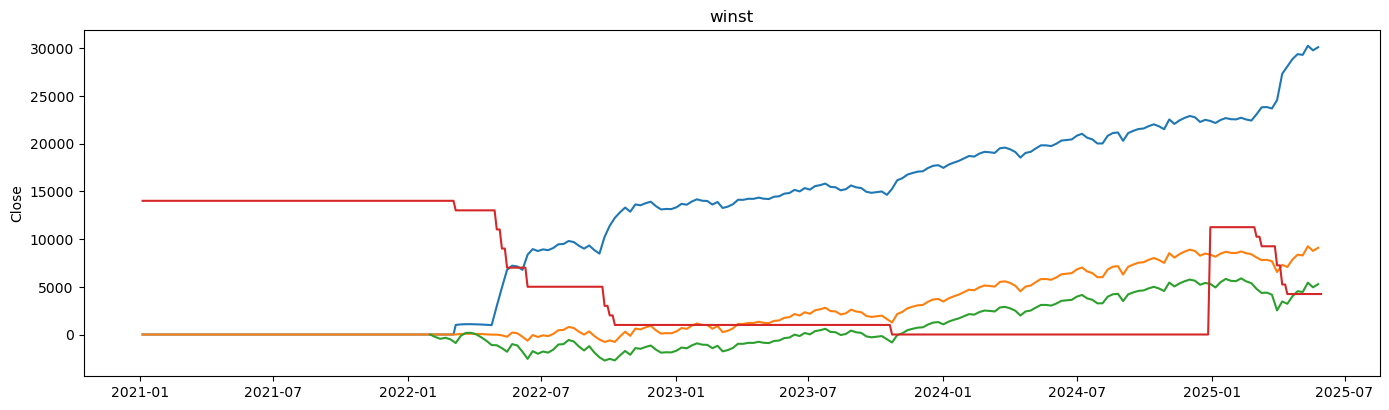

In [1433]:
plt.figure(figsize=(14,4))
sns.lineplot(y = worths,x=indicator_total.index)
sns.lineplot(y = winsts,x=indicator_total.index)
sns.lineplot(y = winst_II,x=indicator_total.loc[start_date:].index)

sns.lineplot(y = start_caps,x=indicator_total.index)

plt.tight_layout()
plt.title('winst')

c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



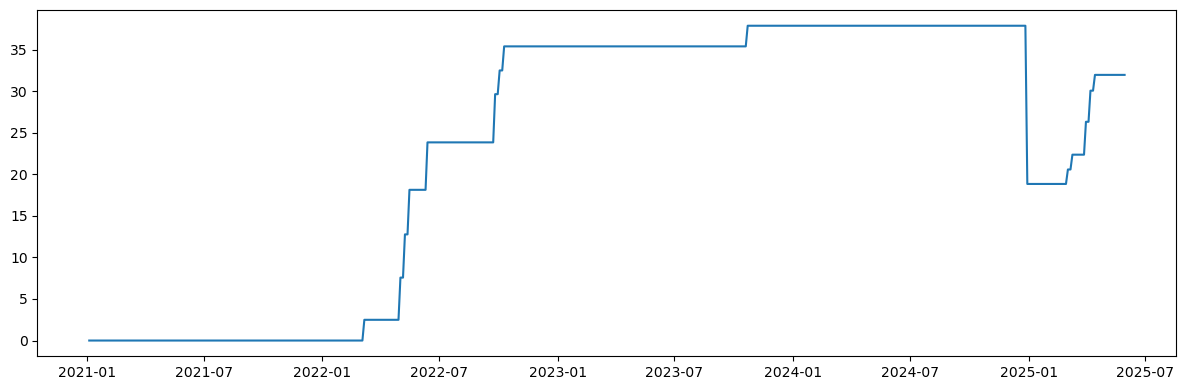

In [1434]:
plt.figure(figsize=(12,4))
sns.lineplot(y = shares_boughts,x=indicator_total.index)
plt.tight_layout()

In [1435]:
winsts = [x for x in winsts if not np.isnan(x)]
print(f'THE WINST OP {indicator_total.index[-1]} met een winst van {winsts[-1]}')

THE WINST OP 2025-05-30 00:00:00 met een winst van 9083.310246205037


In [1436]:
buy_signal = pd.DataFrame(data=indicator_total['buy'],index=indicator_total.index,columns=['buy'])
buy_signal.dropna()
buy_signal[buy_signal.index == '2023-10-23']

,buy
2023-10-23,1.16533


In [1437]:
indicator_total

,Close,High,Low,Open,Volume,200DMA,200DMA perc,50DMA,RSI,RSI_Smoothed,MACD,MACD_signal,MACD_hist,FGI,^VIX,buy,local high,buy signal_drawdown_pct,buy_bin_light,buy_bin_heavy
2021-01-04,358.996674,359.213225,343.516670,353.394107,425078700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,26.969999,NaN,NaN,NaN,0,0
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,25.340000,NaN,NaN,NaN,0,0
2021-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,25.070000,NaN,NaN,NaN,0,0
2021-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,22.370001,NaN,NaN,NaN,0,0
2021-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,21.559999,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-26,589.390015,593.200012,578.429993,586.070007,382958538.0,578.821489,1.82587,567.264291,55.598503,50.744796,0.326803,-2.161426,2.488229,NaN,NaN,NaN,2.285071,NaN,0,0
2025-05-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,18.959999,NaN,2.285071,NaN,0,0
2025-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,19.309999,NaN,2.285071,NaN,0,0
2025-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,19.180000,NaN,2.285071,NaN,0,0


In [1438]:
# 16 weken = 210 dagen
buy_signal['local high'] = buy_signal['buy'].rolling(window=70, min_periods=1).max()

# Bereken de procentuele afname ten opzichte van de piek (bijvoorbeeld: -20% = 20% lager dan de piek)
buy_signal['buy signal_drawdown_pct'] = ((buy_signal['buy'] - buy_signal['local high']) / buy_signal['local high']) * 100
buy_signal['buy_bin_light'] = ((buy_signal['buy signal_drawdown_pct']<-70) & (buy_signal['buy signal_drawdown_pct']>-80)).astype(int)
buy_signal['buy_bin_heavy'] = (buy_signal['buy signal_drawdown_pct']<-80).astype(int)*2


c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\bwava\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



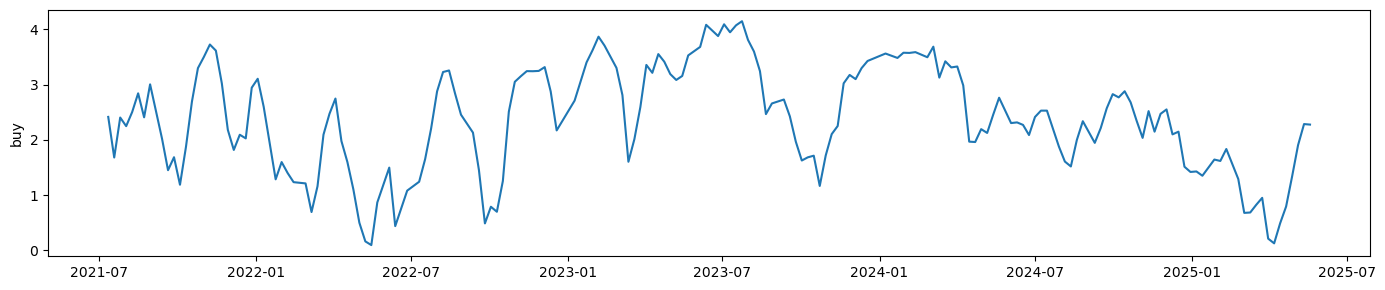

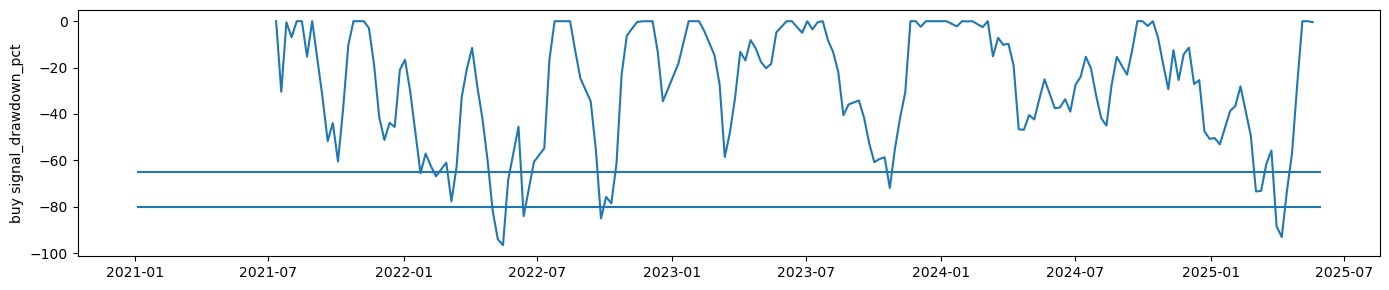

In [1439]:
plt.figure(figsize=(14,3))
indicator_total['buy']
sns.lineplot(buy_signal['buy'])
plt.tight_layout()
plt.figure(figsize=(14,3))
sns.lineplot(buy_signal['buy signal_drawdown_pct'])
plt.hlines(y=-65,xmin=buy_signal.index[0],xmax=buy_signal.index[-1])
plt.hlines(y=-80,xmin=buy_signal.index[0],xmax=buy_signal.index[-1])

plt.tight_layout()

In [1440]:
# indicator_total.dropna().iloc[-1]